In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_jacoco = pd.read_csv("data/jacoco_results.csv")

In [3]:
df_jacoco['results_count'] = df_jacoco[['success', 'fail', 'error', 'unclear']].sum(axis=1)
df_jacoco.head()

,repo_name,build_tool,success,fail,unclear,error,csv,no_code,no_test,no_csv,results_count
0,cloudfoundry/uaa,gradle,0,0,0,1,0,0,0,0,1
1,mongodb/mongo-java-driver,gradle,0,0,0,1,0,0,0,0,1
2,marklogic/marklogic-data-hub,gradle,0,0,0,1,0,0,0,0,1
3,json-path/jsonpath,gradle,0,0,1,0,2,1,1,0,1
4,reactor/reactor-core,gradle,0,0,1,0,3,1,1,2,1


In [4]:
repos_jacoco = df_jacoco['repo_name'].tolist()

In [5]:
df_builds = pd.read_csv("data/local_build_results.csv")
df_builds.head()

,repo_name,build_tool,last_commit_sha,success,fail,unclear,error
0,joinfaces/joinfaces,gradle,6b379a0240fa3002c4321abc919e0d62fcc4164f,0,0,0,1
1,apereo/cas,gradle,32a5e5de26fd70c1229efe7d66676228c663d1fc,0,0,0,1
2,remkop/picocli,gradle,bd48d6f3934c25876931dce5fcc3677dbfc1f410,0,0,0,1
3,shedaniel/roughlyenoughitems,gradle,303fe1b4564b0f7df38df59453e761e4a279dea5,0,0,1,0
4,hortonworks/cloudbreak,gradle,ef36a65f738b4ebc9bf5d932133621ea085808b8,0,0,1,0


In [6]:
repos_success_local = df_builds[df_builds['success'] == 1]['repo_name'].tolist()

In [7]:
len(repos_success_local)

659

In [8]:
list(set(repos_success_local) - set(repos_jacoco))

['apache/logging-log4j2',
 'allure-framework/allure2',
 'mybatis/jpetstore-6',
 'antlr/antlr4',
 'mybatis/mybatis-3',
 'apache/rocketmq',
 'slimefun/slimefun4',
 'cloudnetservice/cloudnet-v3',
 'jenkins-infra/update-center2',
 'edumips64/edumips64',
 'junit-team/junit4']

In [9]:
list(set(repos_jacoco) - set(repos_success_local))

['antlr/antlr',
 'mybatis/jpetstore-',
 'jenkins-infra/update-center',
 'allure-framework/allure',
 'slimefun/slimefun',
 'mybatis/mybatis-',
 'junit-team/junit',
 'apache/logging-log4j',
 'edumips64/edumips',
 'cloudnetservice/cloudnet-v']

### Manually fix missing data from logs

In [10]:
df_jacoco[df_jacoco['repo_name'] == 'apache/rocketmq']

,repo_name,build_tool,success,fail,unclear,error,csv,no_code,no_test,no_csv,results_count


In [11]:
df_jacoco.loc[-1] = ['apache/rocketmq', 'maven', 0, 0, 0, 1, 0, 0, 0, 0, 1]
df_jacoco.index = df_jacoco.index + 1  # shifting index
df_jacoco = df_jacoco.sort_index(axis=0, ascending=True)  # sorting by index

In [12]:
df_jacoco[df_jacoco['repo_name'] == 'apache/rocketmq']

,repo_name,build_tool,success,fail,unclear,error,csv,no_code,no_test,no_csv,results_count
0,apache/rocketmq,maven,0,0,0,1,0,0,0,0,1


### Coverage results

In [13]:
df_coverage = pd.read_csv("data/jacoco_coverage_results.csv")
df_coverage.head()

,repo_name,build_tool,path,instruction_missed,instruction_covered,branch_missed,branch_covered,line_missed,line_covered,complexity_missed,complexity_covered,method_missed,method_covered
0,apache/syncope,maven,apache_syncope/ext/elasticsearch/persistence-j...,677,475,72,39,151,110,80,24,31,12
1,iluwatar/java-design-patterns,maven,iluwatar_java-design-patterns/object-pool\n,6,192,0,2,3,46,1,13,1,12
2,apache/jena,maven,apache_jena/jena-db/jena-tdb2\n,7728,13683,920,897,1845,3264,1074,1130,463,820
3,iluwatar/java-design-patterns,maven,iluwatar_java-design-patterns/fanout-fanin\n,13,154,0,0,5,30,2,11,2,11
4,knowm/xchange,maven,knowm_xchange/xchange-tradeogre\n,1807,29,234,0,164,3,238,2,121,2


In [14]:
coverages = df_coverage.groupby(by=['repo_name']).sum()['branch_covered']*100 / (df_coverage.groupby(by=['repo_name']).sum()['branch_missed'] + df_coverage.groupby(by=['repo_name']).sum()['branch_covered'])
coverage_df = pd.DataFrame(coverages, columns=['coverage'])
coverage_df.reset_index(level=0, inplace=True)
coverage_df['coverage'] = coverage_df['coverage'].apply(lambda x: round(x, 2))
coverage_df.head()

,repo_name,coverage
0,actiontech/dble,8.02
1,adobe-consulting-services/acs-aem-commons,48.47
2,adorsys/keycloak-config-cli,4.71
3,alibaba/easyexcel,36.06
4,alibaba/nacos,11.13


In [15]:
if np.isnan(coverage_df['coverage']).any():
  print("There are NaN values, I need to remove")

There are NaN values, I need to remove


In [16]:
coverage_df[coverage_df['coverage'].isna()]

,repo_name,coverage
25,apache/maven-surefire,NaN
94,fabric8io/docker-maven-plugin,NaN


In [17]:
df_coverage[df_coverage['repo_name'] == 'apache/maven-surefire']['path'].values

array(['apache_maven-surefire/surefire-its/src/test/resources/surefire-257-rerunningTests/module1\n',
       'apache_maven-surefire/surefire-its/src/test/resources/surefire-257-rerunningTests/module2\n'],
      dtype=object)

In [18]:
df_coverage[df_coverage['repo_name'] == 'fabric8io/docker-maven-plugin']['path'].values

array(['fabric8io_docker-maven-plugin/samples/helloworld\n',
       'fabric8io_docker-maven-plugin/it/helloworld\n'], dtype=object)

In [19]:
df_jacoco[df_jacoco['repo_name'] == 'apache/maven-surefire']

,repo_name,build_tool,success,fail,unclear,error,csv,no_code,no_test,no_csv,results_count
604,apache/maven-surefire,maven,4,20,23,0,2,252,13,2,47


In [20]:
df_jacoco.loc[df_jacoco['repo_name'] == 'apache/maven-surefire', 'no_csv'] = 4
df_jacoco.loc[df_jacoco['repo_name'] == 'apache/maven-surefire', 'csv'] = 0
df_jacoco[df_jacoco['repo_name'] == 'apache/maven-surefire']

,repo_name,build_tool,success,fail,unclear,error,csv,no_code,no_test,no_csv,results_count
604,apache/maven-surefire,maven,4,20,23,0,0,252,13,4,47


In [21]:
df_jacoco[df_jacoco['repo_name'] == 'fabric8io/docker-maven-plugin']

,repo_name,build_tool,success,fail,unclear,error,csv,no_code,no_test,no_csv,results_count
436,fabric8io/docker-maven-plugin,maven,3,0,1,0,2,23,16,1,4


In [22]:
df_jacoco.loc[df_jacoco['repo_name'] == 'fabric8io/docker-maven-plugin', 'no_csv'] = 3
df_jacoco.loc[df_jacoco['repo_name'] == 'fabric8io/docker-maven-plugin', 'csv'] = 0
df_jacoco[df_jacoco['repo_name'] == 'fabric8io/docker-maven-plugin']

,repo_name,build_tool,success,fail,unclear,error,csv,no_code,no_test,no_csv,results_count
436,fabric8io/docker-maven-plugin,maven,3,0,1,0,0,23,16,3,4


In [23]:
coverage_df = coverage_df.drop([25, 94], axis=0)
coverage_df.shape[0]

310

In [24]:
coverage_df[coverage_df['coverage'] == 0]

,repo_name,coverage
78,docker-java/docker-java,0.0
82,eclipse-ee4j/glassfish,0.0
113,gwtmaterialdesign/gwt-material,0.0
149,jensgerdes/sonar-pmd,0.0
182,morphiaorg/morphia,0.0
195,netflix/astyanax,0.0
201,nlpchina/elasticsearch-sql,0.0
298,wildfly/quickstart,0.0


In [25]:
print(df_coverage[df_coverage['repo_name'] == 'docker-java/docker-java']['path'].values)
print(df_coverage[df_coverage['repo_name'] == 'eclipse-ee4j/glassfish']['path'].values)
print(df_coverage[df_coverage['repo_name'] == 'gwtmaterialdesign/gwt-material']['path'].values)
print(df_coverage[df_coverage['repo_name'] == 'jensgerdes/sonar-pmd']['path'].values)
print(df_coverage[df_coverage['repo_name'] == 'morphiaorg/morphia']['path'].values)
print(df_coverage[df_coverage['repo_name'] == 'netflix/astyanax']['path'].values)
print(df_coverage[df_coverage['repo_name'] == 'nlpchina/elasticsearch-sql']['path'].values)
print(df_coverage[df_coverage['repo_name'] == 'wildfly/quickstart']['path'].values)

['ker-java_docker-java/docker-java-api\n']
['ipse-ee4j_glassfish/appserver/tests/appserv-tests/devtests/web/ha/cluster-tests/simple-failover-modified-attribute\n'
 'ipse-ee4j_glassfish/appserver/tests/appserv-tests/devtests/web/ha/cluster-tests/simple-failover-modified-session\n'
 'ipse-ee4j_glassfish/appserver/tests/appserv-tests/devtests/ejb/ee/cluster-tests/method-checkpoint\n'
 'ipse-ee4j_glassfish/appserver/tests/appserv-tests/devtests/ejb/ee/cluster-tests/simple-failover\n'
 'ipse-ee4j_glassfish/appserver/tests/appserv-tests/devtests/ejb/ee/cluster-tests/multi-restart\n'
 'ipse-ee4j_glassfish/appserver/tests/appserv-tests/devtests/ejb/ee/cluster-tests/instance-restart-test\n'
 'ipse-ee4j_glassfish/appserver/tests/appserv-tests/devtests/web/ha/cluster-tests/simple-failover\n'
 'ipse-ee4j_glassfish/appserver/tests/appserv-tests/devtests/ejb/ee/cluster-tests/asynctest\n'
 'ipse-ee4j_glassfish/appserver/tests/appserv-tests/devtests/ejb/ee/cluster-tests/ha-web\n'
 'ipse-ee4j_glassfish

In [26]:
print((coverage_df['coverage'] < 0).sum())
print((coverage_df['coverage'] > 100).sum())
print((coverage_df['coverage'] == 0).sum())
print((coverage_df['coverage'] == 100).sum())

0
0
8
4


In [27]:
print((coverage_df['coverage'] >= 95).sum())
print(((coverage_df['coverage'] >= 80) & (coverage_df['coverage'] < 95)).sum())
print(((coverage_df['coverage'] >= 60) & (coverage_df['coverage'] < 80)).sum())
print(((coverage_df['coverage'] >= 20) & (coverage_df['coverage'] < 60)).sum())
print(((coverage_df['coverage'] >= 0) & (coverage_df['coverage'] < 20)).sum())

9
31
58
129
83


In [28]:
print("{:.1f}%".format((coverage_df['coverage'] >= 95).sum() * 100 / coverage_df.shape[0]))
print("{:.1f}%".format(((coverage_df['coverage'] >= 80) & (coverage_df['coverage'] < 95)).sum() * 100 / coverage_df.shape[0]))
print("{:.1f}%".format(((coverage_df['coverage'] >= 60) & (coverage_df['coverage'] < 80)).sum() * 100 / coverage_df.shape[0]))
print("{:.1f}%".format(((coverage_df['coverage'] >= 20) & (coverage_df['coverage'] < 60)).sum() * 100 / coverage_df.shape[0]))
print("{:.1f}%".format(((coverage_df['coverage'] >= 0) & (coverage_df['coverage'] < 20)).sum() * 100 / coverage_df.shape[0]))

2.9%
10.0%
18.7%
41.6%
26.8%


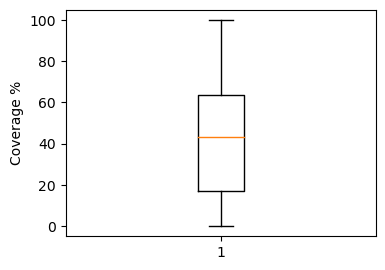

In [29]:
plt.rcParams.update({'figure.figsize':(4,3), 'figure.dpi':100})
fig1, ax1 = plt.subplots()
ax1.set_ylabel('Coverage %')
ax1.boxplot(coverage_df['coverage'])
plt.show()

In [30]:
all_count = df_jacoco.shape[0]
maven_count = df_jacoco[df_jacoco['build_tool'] == 'maven'].shape[0]
gradle_count = df_jacoco[df_jacoco['build_tool'] == 'gradle'].shape[0]

print("count of all projects: {0}".format(all_count))
print("count of maven projects: {0}".format(maven_count))
print("count of gradle projects: {0}".format(gradle_count))
print("percentage of maven projects: {:.2f}%".format(maven_count*100/all_count))
print("percentage of gradle projects: {:.2f}%".format(gradle_count*100/all_count))

count of all projects: 659
count of maven projects: 457
count of gradle projects: 202
percentage of maven projects: 69.35%
percentage of gradle projects: 30.65%


In [31]:
maven_without_code = df_jacoco[(df_jacoco['build_tool'] == 'maven') & (df_jacoco['results_count'] == 0) & (df_jacoco['no_test'] == 0) & (df_jacoco['no_code'] > 0)].shape[0]
print("count of maven projects without any code: {0}".format(maven_without_code))
print("percentage of maven projects without any code: {:.2f}%".format(maven_without_code*100/maven_count))

count of maven projects without any code: 14
percentage of maven projects without any code: 3.06%


In [32]:
gradle_without_code = df_jacoco[(df_jacoco['no_test'] == 0) & (df_jacoco['csv'] == 0) & (df_jacoco['no_csv'] == 0) & (df_jacoco['build_tool'] == 'gradle') & (df_jacoco['no_code'] > 0)].shape[0]
print("count of gradle projects without any code: {0}".format(gradle_without_code))
print("percentage of gradle projects without any code: {:.2f}%".format(gradle_without_code*100/gradle_count))


count of gradle projects without any code: 23
percentage of gradle projects without any code: 11.39%


In [33]:
print("count of all projects without any code: {0}".format(maven_without_code + gradle_without_code))
print("percentage of all projects without any code: {:.2f}%".format((maven_without_code+gradle_without_code)*100/all_count))

count of all projects without any code: 37
percentage of all projects without any code: 5.61%


In [34]:

maven_no_test = df_jacoco[(df_jacoco['build_tool'] == 'maven') & (df_jacoco['no_test'] > 0) & (df_jacoco['results_count'] == 0)].shape[0]
gradle_no_test = df_jacoco[(df_jacoco['no_test'] > 0) & (df_jacoco['csv'] == 0) & (df_jacoco['no_csv'] == 0) & (df_jacoco['build_tool'] == 'gradle')].shape[0]
all_no_test = maven_no_test + gradle_no_test

print("count of all projects without any test: {0}".format(all_no_test))
print("count of maven projects without any test: {0}".format(maven_no_test))
print("count of gradle projects without any test: {0}".format(gradle_no_test))
print("percentage of all projects without any test: {:.2f}%".format(all_no_test*100/all_count))
print("percentage of maven projects without any test: {:.2f}%".format(maven_no_test*100/maven_count))
print("percentage of gradle projects without any test: {:.2f}%".format(gradle_no_test*100/gradle_count))

count of all projects without any test: 23
count of maven projects without any test: 11
count of gradle projects without any test: 12
percentage of all projects without any test: 3.49%
percentage of maven projects without any test: 2.41%
percentage of gradle projects without any test: 5.94%


In [35]:
# remove repos with no code

no_code_repos = df_jacoco[(df_jacoco['build_tool'] == 'maven') & (df_jacoco['results_count'] == 0) & (df_jacoco['no_test'] == 0) & (df_jacoco['no_code'] > 0)].repo_name.tolist()
no_code_repos = no_code_repos + (df_jacoco[(df_jacoco['no_test'] == 0) & (df_jacoco['csv'] == 0) & (df_jacoco['no_csv'] == 0) & (df_jacoco['build_tool'] == 'gradle') & (df_jacoco['no_code'] > 0)].repo_name.tolist())
df_jacoco = df_jacoco[~df_jacoco['repo_name'].isin(no_code_repos)]
df_jacoco.shape[0]

622

In [36]:
# remove repos with no test

no_test_repos = df_jacoco[(df_jacoco['no_test'] > 0) & (df_jacoco['results_count'] == 0)].repo_name.tolist()
no_test_repos = no_test_repos + df_jacoco[(df_jacoco['no_test'] > 0) & (df_jacoco['csv'] == 0) & (df_jacoco['no_csv'] == 0) & (df_jacoco['build_tool'] == 'gradle')].repo_name.tolist()
df_jacoco = df_jacoco[~df_jacoco['repo_name'].isin(no_test_repos)]
df_jacoco.shape[0]

599

In [37]:
all_count = df_jacoco.shape[0]
maven_count = df_jacoco[df_jacoco['build_tool'] == 'maven'].shape[0]
gradle_count = df_jacoco[df_jacoco['build_tool'] == 'gradle'].shape[0]

print("count of all projects: {0}".format(all_count))
print("count of maven projects: {0}".format(maven_count))
print("count of gradle projects: {0}".format(gradle_count))
print("percentage of maven projects: {:.2f}%".format(maven_count*100/all_count))
print("percentage of gradle projects: {:.2f}%".format(gradle_count*100/all_count))

count of all projects: 599
count of maven projects: 432
count of gradle projects: 167
percentage of maven projects: 72.12%
percentage of gradle projects: 27.88%


In [38]:
all_with_no_test = df_jacoco[df_jacoco['no_test'] > 0].shape[0]
maven_with_no_test = df_jacoco[(df_jacoco['build_tool'] == 'maven') & (df_jacoco['no_test'] > 0)].shape[0]
gradle_with_no_test = df_jacoco[(df_jacoco['build_tool'] == 'gradle') & (df_jacoco['no_test'] > 0)].shape[0]
print("count of all projects with at least one path without any test: {0}".format(all_with_no_test))
print("count of maven projects with at least one path without any test: {0}".format(maven_with_no_test))
print("count of gradle projects with at least one path without any test: {0}".format(gradle_with_no_test))
print("percentage of all projects with at least one path without any test: {:.2f}%".format(all_with_no_test*100/all_count))
print("percentage of maven projects with at least one path without any test: {:.2f}%".format(maven_with_no_test*100/maven_count))
print("percentage of gradle projects with at least one path without any test: {:.2f}%".format(gradle_with_no_test*100/gradle_count))

count of all projects with at least one path without any test: 389
count of maven projects with at least one path without any test: 280
count of gradle projects with at least one path without any test: 109
percentage of all projects with at least one path without any test: 64.94%
percentage of maven projects with at least one path without any test: 64.81%
percentage of gradle projects with at least one path without any test: 65.27%


In [39]:
all_with_csv = df_jacoco[df_jacoco['csv'] > 0].shape[0]
maven_with_csv = df_jacoco[(df_jacoco['build_tool'] == 'maven') & (df_jacoco['csv'] > 0)].shape[0]
gradle_with_csv = df_jacoco[(df_jacoco['build_tool'] == 'gradle') & (df_jacoco['csv'] > 0)].shape[0]
print("count of all projects with at least one jacoco csv: {0}".format(all_with_csv))
print("count of maven projects with at least one jacoco csv: {0}".format(maven_with_csv))
print("count of gradle projects with at least one jacoco csv: {0}".format(gradle_with_csv))
print("percentage of all projects with at least one jacoco csv: {:.2f}%".format(all_with_csv*100/all_count))
print("percentage of maven projects with at least one jacoco csv: {:.2f}%".format(maven_with_csv*100/all_with_csv))
print("percentage of gradle projects with at least one jacoco csv: {:.2f}%".format(gradle_with_csv*100/all_with_csv))

count of all projects with at least one jacoco csv: 310
count of maven projects with at least one jacoco csv: 237
count of gradle projects with at least one jacoco csv: 73
percentage of all projects with at least one jacoco csv: 51.75%
percentage of maven projects with at least one jacoco csv: 76.45%
percentage of gradle projects with at least one jacoco csv: 23.55%


In [40]:
all_with_csv = df_jacoco[df_jacoco['csv'] == 0].shape[0]
maven_with_csv = df_jacoco[(df_jacoco['build_tool'] == 'maven') & (df_jacoco['csv'] == 0)].shape[0]
gradle_with_csv = df_jacoco[(df_jacoco['build_tool'] == 'gradle') & (df_jacoco['csv'] == 0)].shape[0]
print("count of all projects with no jacoco csv: {0}".format(all_with_csv))
print("count of maven projects with no jacoco csv: {0}".format(maven_with_csv))
print("count of gradle projects with no jacoco csv: {0}".format(gradle_with_csv))
print("percentage of all projects with no jacoco csv: {:.2f}%".format(all_with_csv*100/all_count))
print("percentage of maven projects with no jacoco csv: {:.2f}%".format(maven_with_csv*100/maven_count))
print("percentage of gradle projects with no jacoco csv: {:.2f}%".format(gradle_with_csv*100/gradle_count))

count of all projects with no jacoco csv: 289
count of maven projects with no jacoco csv: 195
count of gradle projects with no jacoco csv: 94
percentage of all projects with no jacoco csv: 48.25%
percentage of maven projects with no jacoco csv: 45.14%
percentage of gradle projects with no jacoco csv: 56.29%


In [41]:
all_only_csv = df_jacoco[(df_jacoco['fail'] == 0) & (df_jacoco['error'] == 0)  & (df_jacoco['no_csv'] == 0) & (df_jacoco['csv'] > 0)].shape[0]
maven_only_csv = df_jacoco[(df_jacoco['build_tool'] == 'maven') & (df_jacoco['fail'] == 0) & (df_jacoco['error'] == 0) & (df_jacoco['no_csv'] == 0) & (df_jacoco['csv'] > 0)].shape[0]
gradle_only_csv = df_jacoco[(df_jacoco['build_tool'] == 'gradle')& (df_jacoco['fail'] == 0) & (df_jacoco['error'] == 0) & (df_jacoco['no_csv'] == 0) & (df_jacoco['csv'] > 0)].shape[0]
print("count of projects that don't miss any csv output: {0}".format(all_only_csv))
print("count of maven projects that don't miss any csv output: {0}".format(maven_only_csv))
print("count of gradle projects that don't miss any csv output: {0}".format(gradle_only_csv))
print("percentage of all projects that don't miss any csv output: {:.2f}%".format(all_only_csv*100/all_with_csv))
print("percentage of maven projects that don't miss any csv output: {:.2f}%".format(maven_only_csv*100/maven_count))
print("percentage of gradle projects that don't miss any csv output: {:.2f}%".format(gradle_only_csv*100/gradle_count))

count of projects that don't miss any csv output: 172
count of maven projects that don't miss any csv output: 117
count of gradle projects that don't miss any csv output: 55
percentage of all projects that don't miss any csv output: 59.52%
percentage of maven projects that don't miss any csv output: 27.08%
percentage of gradle projects that don't miss any csv output: 32.93%


In [42]:
repos_all_csv = df_jacoco[(df_jacoco['fail'] == 0) & (df_jacoco['error'] == 0)  & (df_jacoco['no_csv'] == 0) & (df_jacoco['csv'] > 0)].repo_name.tolist()
complete_coverage_df = coverage_df[coverage_df['repo_name'].isin(repos_all_csv)]
count_complete_coverage = complete_coverage_df.shape[0]
count_complete_coverage

172

In [43]:
partial_coverage_df = coverage_df[~coverage_df['repo_name'].isin(repos_all_csv)]
partial_coverage_df.shape[0]

138

In [44]:
df_jacoco[df_jacoco['repo_name'].isin(partial_coverage_df.repo_name.tolist())].head()

,repo_name,build_tool,success,fail,unclear,error,csv,no_code,no_test,no_csv,results_count
5,reactor/reactor-core,gradle,0,0,1,0,3,1,1,2,1
18,micronaut-projects/micronaut-starter,gradle,0,0,1,0,8,0,2,4,1
24,odpi/egeria,gradle,0,0,1,0,52,13,210,27,1
32,hyperledger/fabric-chaincode-java,gradle,0,0,1,0,1,2,5,4,1
46,bonitasoft/bonita-engine,gradle,0,0,1,0,54,6,15,1,1


In [45]:
partial_coverage_df_plot = df_jacoco[df_jacoco['repo_name'].isin(partial_coverage_df.repo_name.tolist())]
partial_coverage_df_plot = partial_coverage_df_plot[['repo_name', 'csv', 'no_test']]
partial_coverage_df_plot.head()

,repo_name,csv,no_test
5,reactor/reactor-core,3,1
18,micronaut-projects/micronaut-starter,8,2
24,odpi/egeria,52,210
32,hyperledger/fabric-chaincode-java,1,5
46,bonitasoft/bonita-engine,54,15


In [46]:
from operator import truediv, add
left = list( map(truediv, partial_coverage_df_plot['csv'].tolist(), list( map(add, partial_coverage_df_plot['csv'].tolist(), partial_coverage_df_plot['no_test'].tolist()) )) )
right = list( map(truediv, partial_coverage_df_plot['no_test'].tolist(), list( map(add, partial_coverage_df_plot['csv'].tolist(), partial_coverage_df_plot['no_test'].tolist()) )) )

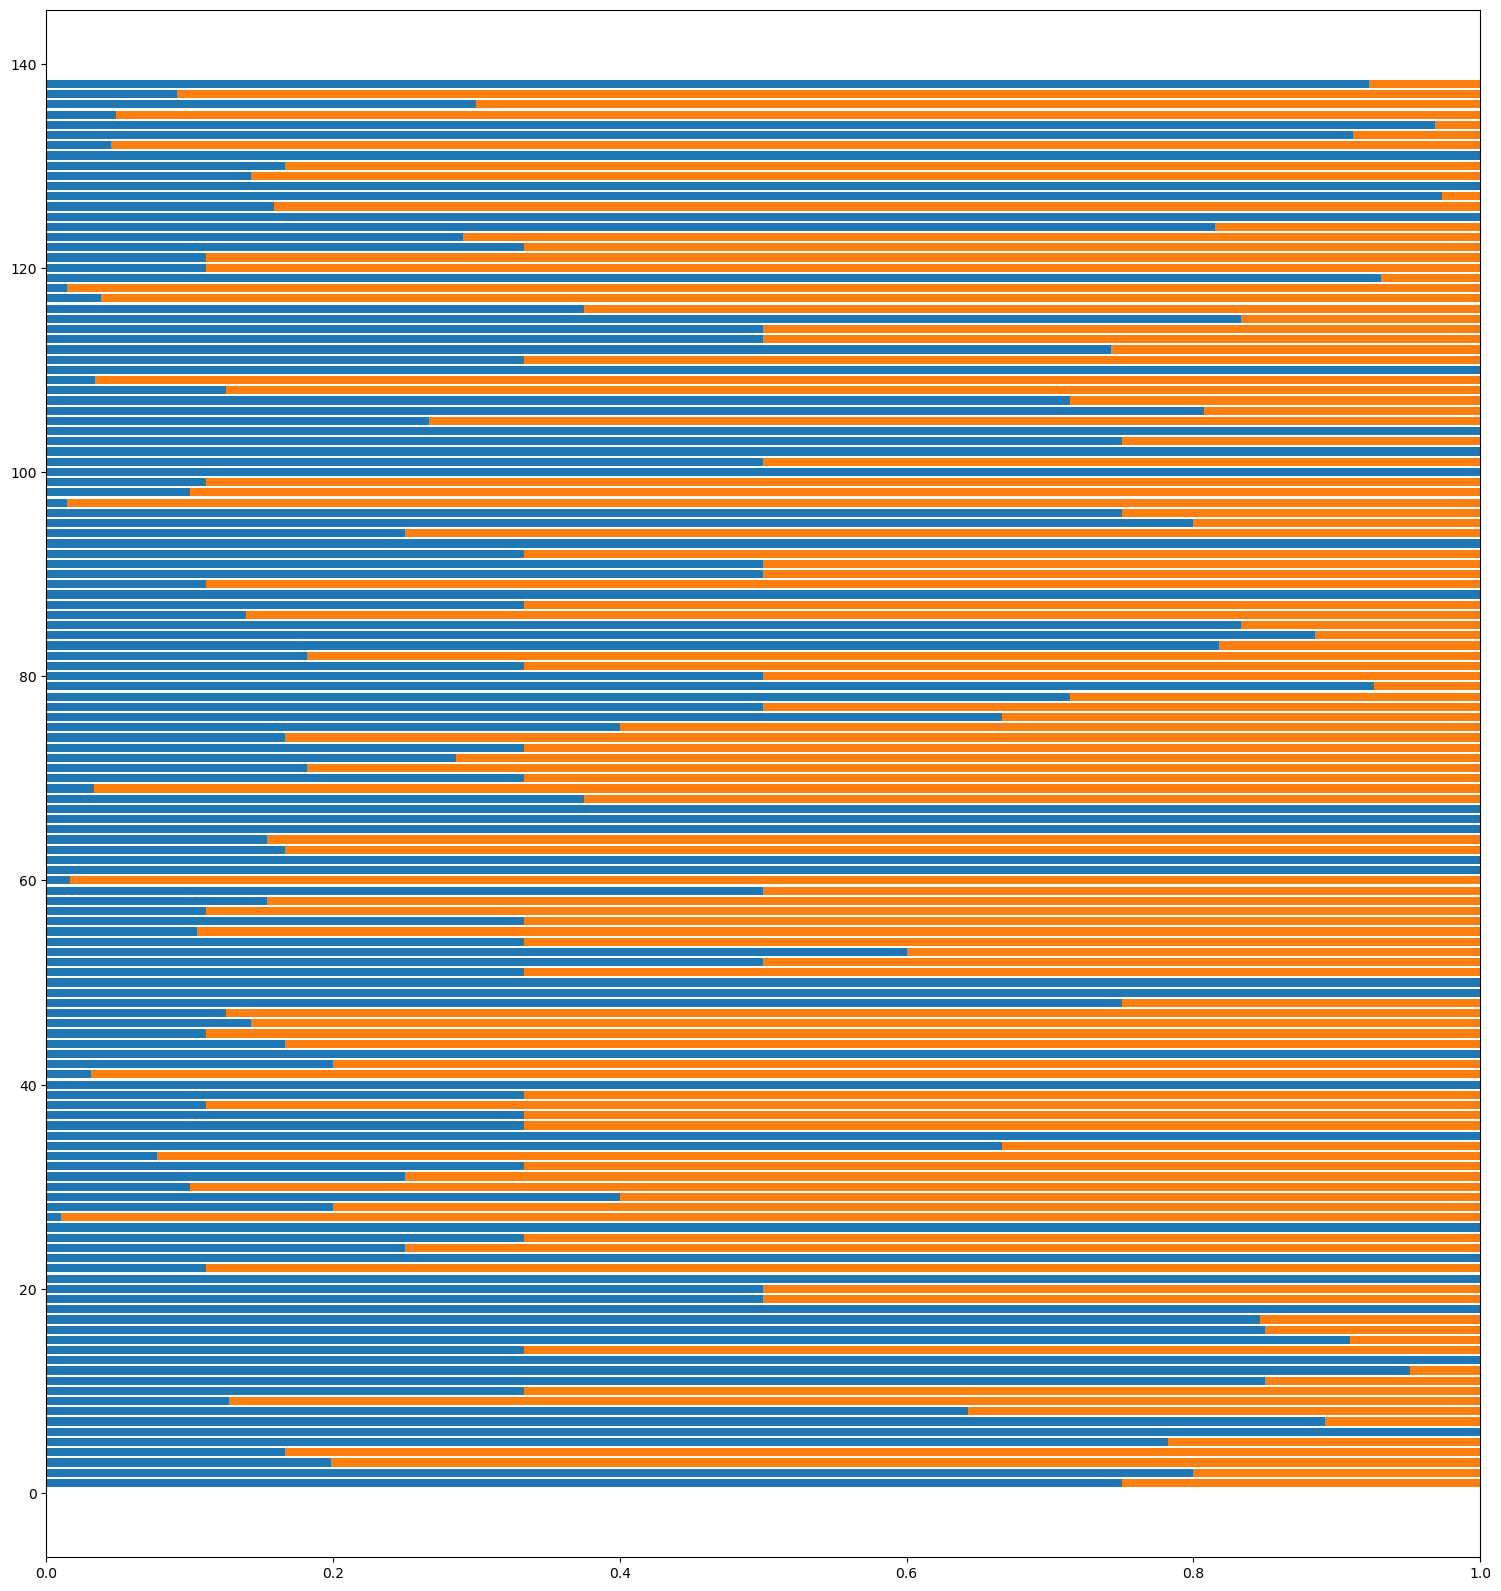

In [47]:
fig = plt.gcf()
fig.set_size_inches(18.5, 20.5)
plt.barh(list(range(1,139)), left)
plt.barh(list(range(1,139)), right, left = left)
plt.show()

In [48]:
df_jacoco[df_jacoco['repo_name'].isin(partial_coverage_df.repo_name.tolist())]['build_tool'].value_counts()

maven     120
gradle     18
Name: build_tool, dtype: int64

In [49]:
138/310

0.44516129032258067

In [50]:
172/310

0.5548387096774193

In [51]:
(df_jacoco[df_jacoco['repo_name'].isin(partial_coverage_df.repo_name.tolist())]['no_test'] > 0).sum()

113

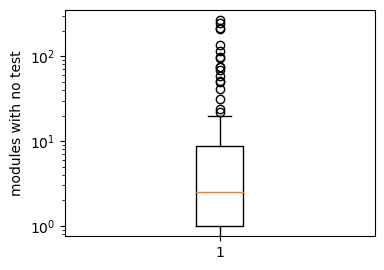

In [52]:
plt.rcParams.update({'figure.figsize':(4,3), 'figure.dpi':100})
fig1, ax1 = plt.subplots()
ax1.set_ylabel('modules with no test')
ax1.boxplot(df_jacoco[df_jacoco['repo_name'].isin(partial_coverage_df.repo_name.tolist())]['no_test'])
ax1.set_yscale('log')
plt.show()

In [53]:
more_than_95 = (complete_coverage_df['coverage'] >= 95).sum()
between_95_80 = ((complete_coverage_df['coverage'] >= 80) & (complete_coverage_df['coverage'] < 95)).sum()
between_80_60 = ((complete_coverage_df['coverage'] >= 60) & (complete_coverage_df['coverage'] < 80)).sum()
between_60_20 = ((complete_coverage_df['coverage'] >= 20) & (complete_coverage_df['coverage'] < 60)).sum()
between_20_0 = ((complete_coverage_df['coverage'] >= 0) & (complete_coverage_df['coverage'] < 20)).sum()


print("{0} projects have >95% coverage which is {1:.2f}%".format(more_than_95, more_than_95*100/count_complete_coverage))
print("{0} projects have 95%> >80% coverage which is {1:.2f}%".format(between_95_80, between_95_80*100/count_complete_coverage))
print("{0} projects have 80%> >60% coverage which is {1:.2f}%".format(between_80_60, between_80_60*100/count_complete_coverage))
print("{0} projects have 60%> >20% coverage which is {1:.2f}%".format(between_60_20, between_60_20*100/count_complete_coverage))
print("{0} projects have 20%> >0% coverage which is {1:.2f}%".format(between_20_0, between_20_0*100/count_complete_coverage))


5 projects have >95% coverage which is 2.91%
19 projects have 95%> >80% coverage which is 11.05%
35 projects have 80%> >60% coverage which is 20.35%
65 projects have 60%> >20% coverage which is 37.79%
48 projects have 20%> >0% coverage which is 27.91%


In [54]:
more_than_95  = (partial_coverage_df['coverage'] >= 95).sum()
between_95_80 = ((partial_coverage_df['coverage'] >= 80) & (partial_coverage_df['coverage'] < 95)).sum()
between_80_60 = ((partial_coverage_df['coverage'] >= 60) & (partial_coverage_df['coverage'] < 80)).sum()
between_60_20 = ((partial_coverage_df['coverage'] >= 20) & (partial_coverage_df['coverage'] < 60)).sum()
between_20_0  = ((partial_coverage_df['coverage'] >= 0) & (partial_coverage_df['coverage'] < 20)).sum()

print("{0} projects have >95% coverage which is {1:.2f}%".format(more_than_95, more_than_95*100/count_complete_coverage))
print("{0} projects have 95%> >80% coverage which is {1:.2f}%".format(between_95_80, between_95_80*100/count_complete_coverage))
print("{0} projects have 80%> >60% coverage which is {1:.2f}%".format(between_80_60, between_80_60*100/count_complete_coverage))
print("{0} projects have 60%> >20% coverage which is {1:.2f}%".format(between_60_20, between_60_20*100/count_complete_coverage))
print("{0} projects have 20%> >0% coverage which is {1:.2f}%".format(between_20_0, between_20_0*100/count_complete_coverage))


4 projects have >95% coverage which is 2.33%
12 projects have 95%> >80% coverage which is 6.98%
23 projects have 80%> >60% coverage which is 13.37%
64 projects have 60%> >20% coverage which is 37.21%
35 projects have 20%> >0% coverage which is 20.35%


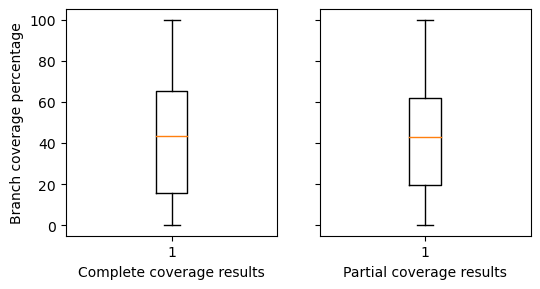

In [55]:
plt.rcParams.update({'figure.figsize':(6,3), 'figure.dpi':100})
fig1, ax1 = plt.subplots(1,2,sharey=True)
ax1[0].set_xlabel('Complete coverage results')
ax1[0].set_ylabel('Branch coverage percentage')
ax1[0].boxplot(complete_coverage_df["coverage"])
# ax1[1].set_ylabel('Count of statuses per project')
ax1[1].set_xlabel('Partial coverage results')
ax1[1].boxplot(partial_coverage_df["coverage"])
plt.show()

In [67]:
print(complete_coverage_df["coverage"].median())
print(partial_coverage_df["coverage"].median())

43.435
42.93


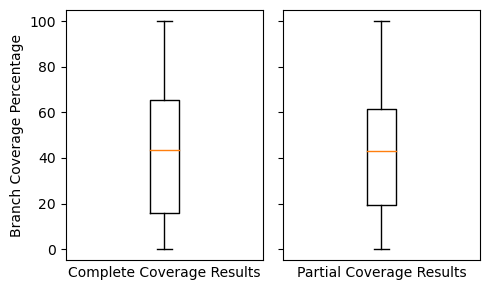

In [56]:
plt.rcParams.update({'figure.figsize':(6,3), 'figure.dpi':100})
fig1, ax1 = plt.subplots(1,2,sharey=True)
ax1[0].set_xlabel('Complete Coverage Results')
ax1[0].set_ylabel('Branch Coverage Percentage')
ax1[0].boxplot(complete_coverage_df["coverage"])
ax1[0].set_xticks([0], ['Complete Coverage Results'])

ax1[1].set_xlabel('Partial Coverage Results')
ax1[1].boxplot(partial_coverage_df["coverage"])
ax1[1].set_xticks([0], ['Partial Coverage Results'])

plt.gcf().set_size_inches(5,3)
plt.tight_layout()
plt.savefig('branch-coverage.pdf', dpi=300)

## Fix repos name and export results

In [57]:
final_df = pd.read_csv('data/selected_projects.csv')
final_df['repo_name'] = final_df['Name']
final_df = final_df[['repo_name']]
display(final_df.head())
print(final_df.shape)

,repo_name
0,1c-syntax/bsl-language-server
1,abhpd/hacktoberfest2021
2,actiontech/dble
3,activiti/activiti
4,adeekshith/watomatic


(1454, 1)


In [58]:
coverage_df.loc[coverage_df['repo_name'] == 'mybatis/jpetstore-', 'repo_name'] = 'mybatis/jpetstore-6'
coverage_df.loc[coverage_df['repo_name'] == 'edumips64/edumips', 'repo_name'] = 'edumips64/edumips64'
coverage_df.loc[coverage_df['repo_name'] == 'slimefun/slimefun', 'repo_name'] = 'slimefun/slimefun4'
coverage_df.loc[coverage_df['repo_name'] == 'junit-team/junit', 'repo_name'] = 'junit-team/junit4'
coverage_df.loc[coverage_df['repo_name'] == 'edumips64/edumips', 'repo_name'] = 'edumips64/edumips64'
coverage_df.loc[coverage_df['repo_name'] == 'mybatis/mybatis-', 'repo_name'] = 'mybatis/mybatis-3'
coverage_df.loc[coverage_df['repo_name'] == 'apache/logging-log4j', 'repo_name'] = 'apache/logging-log4j2'

In [59]:
def label_coverage(x):
    x = float(x)
    if x >= 95:
        return 'Very High'
    elif x >= 80:
        return 'High'
    elif x >= 60:
        return 'Moderate'
    elif x >= 20:
        return 'Low'
    else:
        return 'Very Low'

In [60]:
coverage_df['label'] = coverage_df['coverage'].apply(lambda x: label_coverage(x))
coverage_df

,repo_name,coverage,label
0,actiontech/dble,8.02,Very Low
1,adobe-consulting-services/acs-aem-commons,48.47,Low
2,adorsys/keycloak-config-cli,4.71,Very Low
3,alibaba/easyexcel,36.06,Low
4,alibaba/nacos,11.13,Very Low
...,...,...,...
307,zalando/problem,100.00,Very High
308,zalando/problem-spring-web,100.00,Very High
309,zaproxy/zap-hud,2.85,Very Low
310,zendesk/maxwell,60.88,Moderate


In [61]:
df_results = pd.read_csv('data/combined_results.csv')

for index, row in coverage_df.iterrows():
    df_results.loc[df_results['repo_name'] == row['repo_name'], 'testing_coverage'] = row['coverage']

df_results.to_csv('data/combined_results.csv', index=False)

In [62]:
final_df['testing'] = 'NA'

In [63]:
for index, row in coverage_df.iterrows():
    final_df.loc[final_df['repo_name'] == row['repo_name'], 'testing'] = row['label']

In [64]:
final_df.testing.value_counts()

NA           1144
Low           129
Very Low       83
Moderate       58
High           31
Very High       9
Name: testing, dtype: int64

In [65]:
final_df.to_csv('data/combined_results.csv', index=False)